# Tavus Data Analysis

This notebook contains analysis of Tavus data.

### Overview
- **Users Data**: User accounts and profile information
- **Conversations Data**: Conversation records and metadata
- **Billing Accounts Data**: Billing account information

### Setup
The data is processed through dbt staging models and stored in DuckDB. Please refer to the dbt models for specific sql transformations

### Analysis
- DAU & Engaged Users
- Account level metrics (with dummy data)

# Concise Summary
The high engagement percentage (>80%) indicates strong product-market fit and growing user interest. After the initial months after the launch on Jan 2025, user growth peaked in July, hitting 175 WAU. Following which, WAU has hovered around 125.

The average conversations lengths per user is declining, in conjunction with a greater number of users and overall conversation lengths. This indicates that our user base is maturing, opting for shorter conversations in higher quantity.

From the (dummy) account data, There are distinct user behaviors with specific customers which we should look into for further product development. Customer behaviors vary on conversations length and quantity, where deeper research or qualitative information to conversation topics would provide further insight to use cases.

In [216]:
# Install required packages (run this cell first if packages are missing)
%pip install pandas numpy matplotlib seaborn duckdb

Note: you may need to restart the kernel to use updated packages.


In [217]:
# Import required libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import duckdb
from pathlib import Path

# Set up plotting style
plt.style.use('seaborn-v0_8')
sns.set_palette("husl")

# Connect to DuckDB database
db_path = "tavus_takehome/tavus_database.duckdb"
conn = duckdb.connect(db_path)

In [218]:
# List all tables
tables_query = "SHOW TABLES;"
tables_df = conn.execute(tables_query).fetchdf()
print(tables_df)

                                       name
0                          billing_accounts
1                              conversation
2              int_billing_accounts_metrics
3         int_billing_accounts_metrics_L30D
4   int_billing_accounts_metrics_L30_60_90D
5     int_billing_accounts_metrics_lifetime
6                    int_daily_active_users
7                         int_daily_signups
8                       int_persona_metrics
9                   int_weekly_active_users
10                     mart_account_metrics
11                                  persona
12                     stg_billing_accounts
13                         stg_conversation
14                           stg_date_spine
15                              stg_persona
16                                stg_users
17                                    users


# DAU
Daily Active Users are defined as any user that had at least 1 (not deleted) conversation

[int_daily_active_users.sql](tavus_takehome/models/intermediate/int_daily_active_users.sql) contains the SQL code for it

📊 daily active users data:


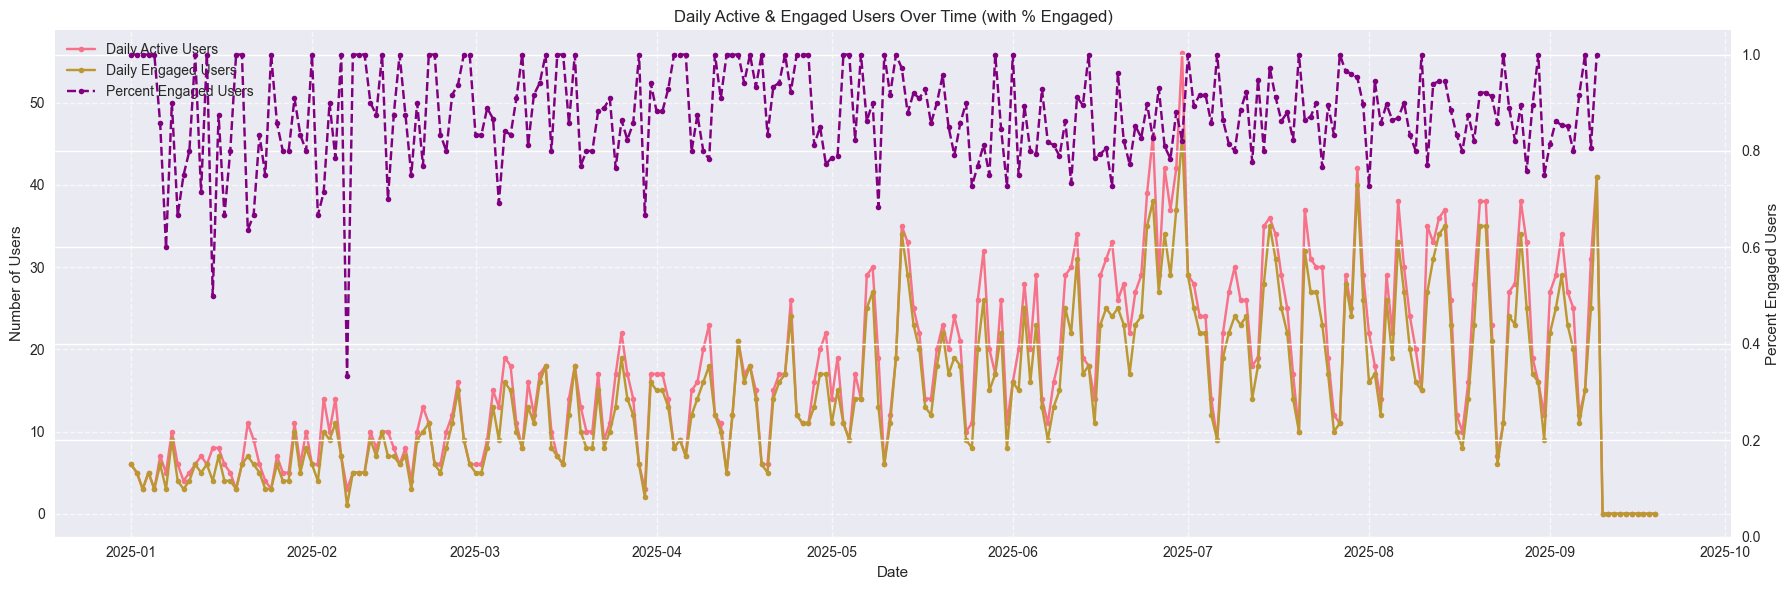


📈 Basic Statistics:
       daily_active_users  daily_engaged_users
count          262.000000           262.000000
mean            17.034351            14.858779
std             10.721964             9.390991
min              0.000000             0.000000
25%              9.000000             7.250000
50%             15.000000            13.000000
75%             25.000000            22.000000
max             56.000000            46.000000


In [219]:
print("📊 daily active users data:")
query = """
SELECT * FROM int_daily_active_users
;
"""

# Execute query and get data
daily_active_users_df = conn.execute(query).fetchdf()
daily_active_users_df['percent_engaged_users'] = daily_active_users_df['daily_engaged_users'] / daily_active_users_df['daily_active_users']

# Convert created_at to datetime if it's not already
daily_active_users_df['date_key'] = pd.to_datetime(daily_active_users_df['date_key'])

fig, ax1 = plt.subplots(figsize=(18, 6))

# Plot daily_active_users and daily_engaged_users on primary y-axis
ax1.plot(
    daily_active_users_df['date_key'],
    daily_active_users_df['daily_active_users'],
    marker='o',
    markersize=4,
    label='Daily Active Users'
)
ax1.plot(
    daily_active_users_df['date_key'],
    daily_active_users_df['daily_engaged_users'],
    marker='o',
    markersize=4,
    label='Daily Engaged Users'
)
ax1.set_xlabel('Date')
ax1.set_ylabel('Number of Users')
ax1.grid(True, linestyle='--', alpha=0.7)

# Create secondary y-axis for percent_engaged_users
ax2 = ax1.twinx()
ax2.plot(
    daily_active_users_df['date_key'],
    daily_active_users_df['percent_engaged_users'],
    color='purple',
    marker='o',
    markersize=4,
    linestyle='--',
    label='Percent Engaged Users'
)
ax2.set_ylabel('Percent Engaged Users')
ax2.set_ylim(0, 1.05)

# Combine legends from both axes
lines_1, labels_1 = ax1.get_legend_handles_labels()
lines_2, labels_2 = ax2.get_legend_handles_labels()
ax1.legend(lines_1 + lines_2, labels_1 + labels_2, loc='upper left')

plt.title('Daily Active & Engaged Users Over Time (with % Engaged)')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# Print some basic statistics
print("\n📈 Basic Statistics:")
print(daily_active_users_df[['daily_active_users', 'daily_engaged_users']].describe())


too noisy, let change it to weekly. There are daily patterns, with weekends dipping

📊 weekly active users data:


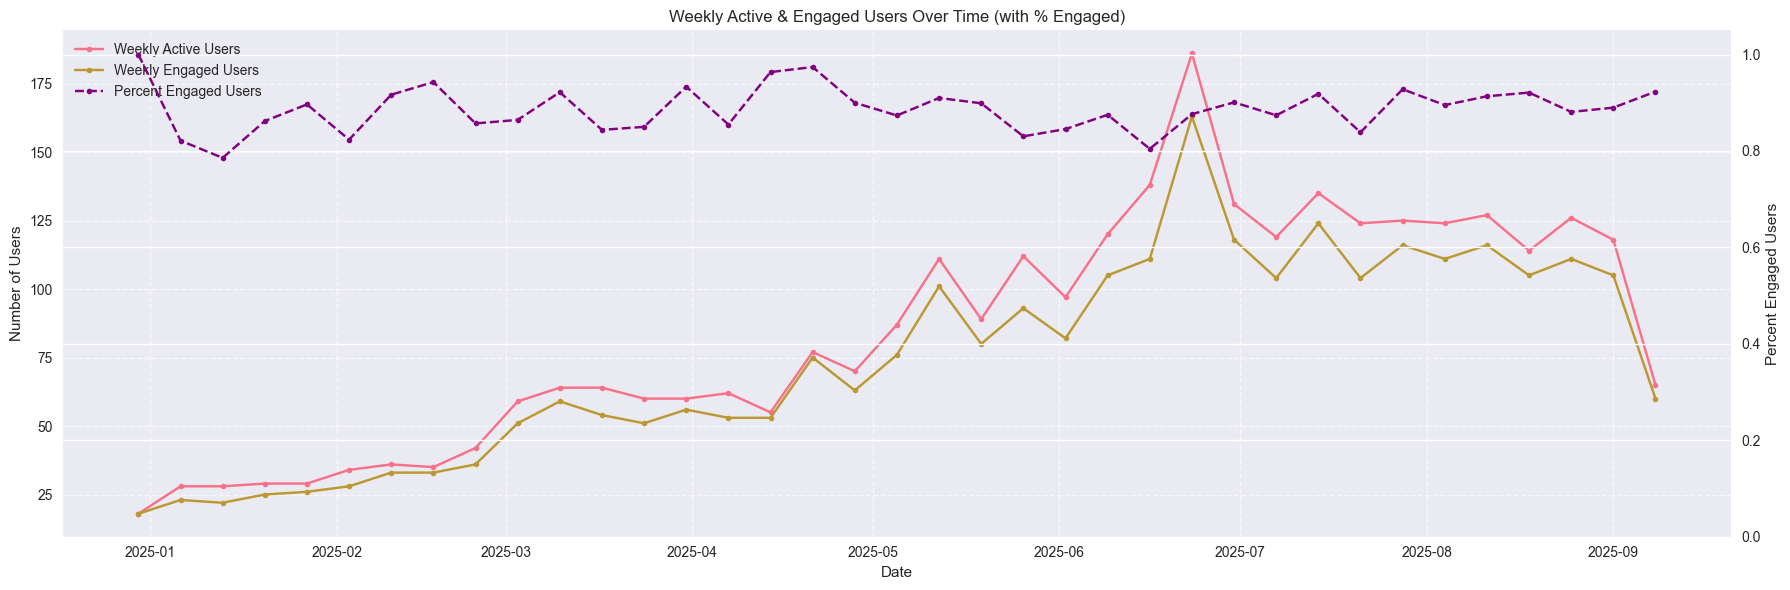

In [220]:

print("📊 weekly active users data:")
# Comprehensive query to get account metrics
query = """
SELECT * FROM int_weekly_active_users
;
"""

# Execute query and get data
weekly_active_users_df = conn.execute(query).fetchdf()
weekly_active_users_df['percent_engaged_users'] = weekly_active_users_df['weekly_engaged_users'] / weekly_active_users_df['weekly_active_users']

# Convert created_at to datetime if it's not already
weekly_active_users_df['week_start_date'] = pd.to_datetime(weekly_active_users_df['week_start_date'])

fig, ax1 = plt.subplots(figsize=(18, 6))

# Plot daily_active_users and daily_engaged_users on primary y-axis
ax1.plot(
    weekly_active_users_df['week_start_date'],
    weekly_active_users_df['weekly_active_users'],
    marker='o',
    markersize=4,
    label='Weekly Active Users'
)
ax1.plot(
    weekly_active_users_df['week_start_date'],
    weekly_active_users_df['weekly_engaged_users'],
    marker='o',
    markersize=4,
    label='Weekly Engaged Users'
)
ax1.set_xlabel('Date')
ax1.set_ylabel('Number of Users')
ax1.grid(True, linestyle='--', alpha=0.7)

# Create secondary y-axis for percent_engaged_users
ax2 = ax1.twinx()
ax2.plot(
    weekly_active_users_df['week_start_date'],
    weekly_active_users_df['percent_engaged_users'],
    color='purple',
    marker='o',
    markersize=4,
    linestyle='--',
    label='Percent Engaged Users'
)
ax2.set_ylabel('Percent Engaged Users')
ax2.set_ylim(0, 1.05)

# Combine legends from both axes
lines_1, labels_1 = ax1.get_legend_handles_labels()
lines_2, labels_2 = ax2.get_legend_handles_labels()
ax1.legend(lines_1 + lines_2, labels_1 + labels_2, loc='upper left')

plt.title('Weekly Active & Engaged Users Over Time (with % Engaged)')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [221]:
weekly_active_users_df.head()

,week_start_date,weekly_active_users,weekly_engaged_users,weekly_total_conversation_length_minutes,weekly_average_conversation_length_minutes,weekly_conversation_count_per_user,percent_engaged_users
0,2024-12-30,18,18,90.0,5.000000,1.722222,1.000000
1,2025-01-06,28,23,111.0,3.964286,2.000000,0.821429
2,2025-01-13,28,22,144.0,5.142857,2.500000,0.785714
3,2025-01-20,29,25,1187.0,40.931034,3.275862,0.862069
4,2025-01-27,29,26,314.0,10.827586,3.379310,0.896552


% of users that are engaged are consistently >80%, which shows keen interest and deep engagement with product. We can further increase this engagement metric, to determine power users to better understand key use cases to lean into for further product development.

Total conversation length (minutes) across all weeks: 33088.00
Average conversation length (minutes) per week: 894.27
Average conversation length (minutes) per user per week: 10.69


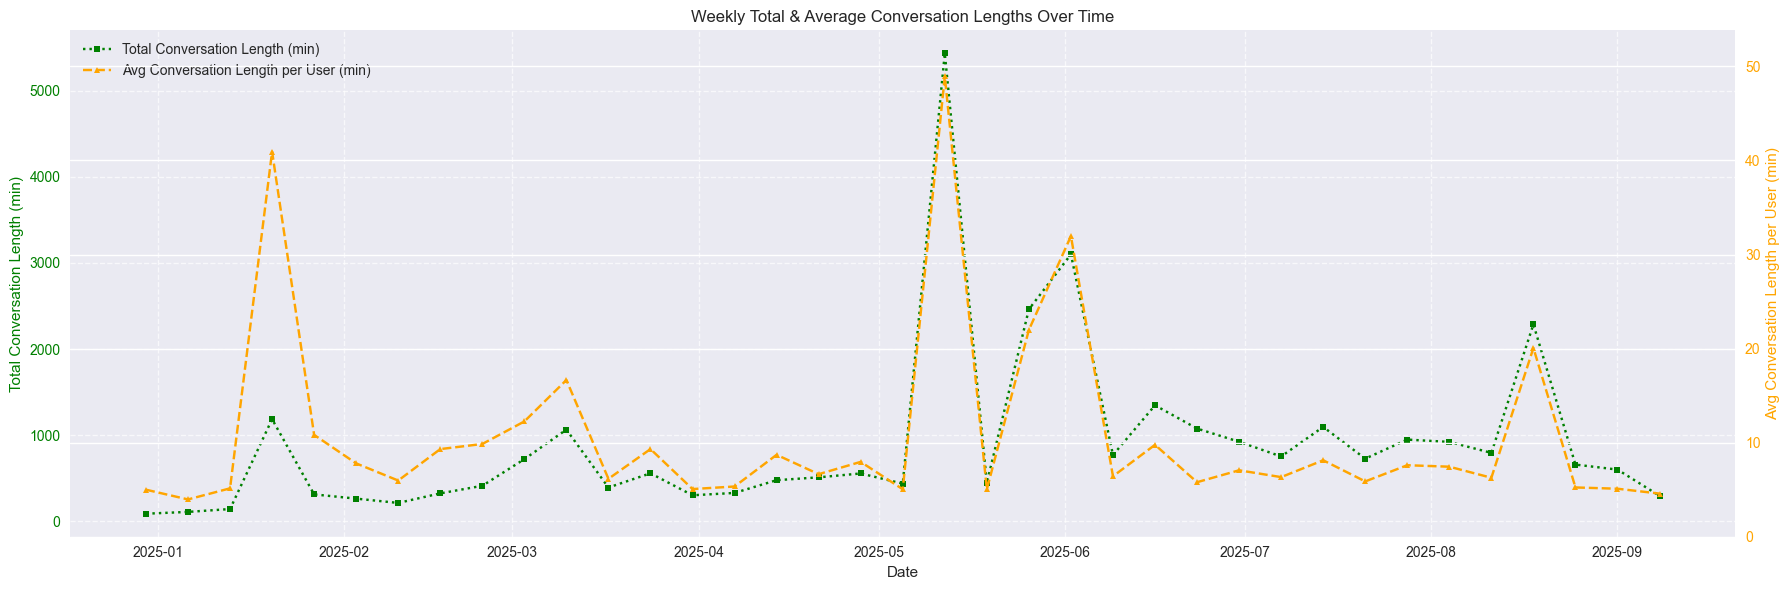

In [222]:

# Calculate total and average conversation length
total_conversation_length = weekly_active_users_df['weekly_total_conversation_length_minutes'].sum()
average_conversation_length_per_week = weekly_active_users_df['weekly_total_conversation_length_minutes'].mean()
average_conversation_length_per_user = (
    weekly_active_users_df['weekly_total_conversation_length_minutes'] / weekly_active_users_df['weekly_active_users']
).mean()

print(f"Total conversation length (minutes) across all weeks: {total_conversation_length:.2f}")
print(f"Average conversation length (minutes) per week: {average_conversation_length_per_week:.2f}")
print(f"Average conversation length (minutes) per user per week: {average_conversation_length_per_user:.2f}")

fig, ax1 = plt.subplots(figsize=(18, 6))

# Plot total conversation length on primary y-axis
ax1.plot(
    weekly_active_users_df['week_start_date'],
    weekly_active_users_df['weekly_total_conversation_length_minutes'],
    marker='s',
    markersize=4,
    linestyle=':',
    color='green',
    label='Total Conversation Length (min)'
)
ax1.set_xlabel('Date')
ax1.set_ylabel('Total Conversation Length (min)', color='green')
ax1.tick_params(axis='y', labelcolor='green')
ax1.grid(True, linestyle='--', alpha=0.7)

# Create secondary y-axis for average conversation length per user
ax2 = ax1.twinx()
ax2.plot(
    weekly_active_users_df['week_start_date'],
    weekly_active_users_df['weekly_average_conversation_length_minutes'],
    color='orange',
    marker='^',
    markersize=4,
    linestyle='--',
    label='Avg Conversation Length per User (min)'
)
ax2.set_ylabel('Avg Conversation Length per User (min)', color='orange')
ax2.tick_params(axis='y', labelcolor='orange')
ax2.set_ylim(0, max(1.05, weekly_active_users_df['weekly_average_conversation_length_minutes'].max() * 1.1))

# Combine legends from both axes
lines_1, labels_1 = ax1.get_legend_handles_labels()
lines_2, labels_2 = ax2.get_legend_handles_labels()
ax1.legend(lines_1 + lines_2, labels_1 + labels_2, loc='upper left')

plt.title('Weekly Total & Average Conversation Lengths Over Time')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

Total conversation count (across all weeks): 114.33
Average conversation count per week: 3.09
Average conversation count per user per week: 3.09


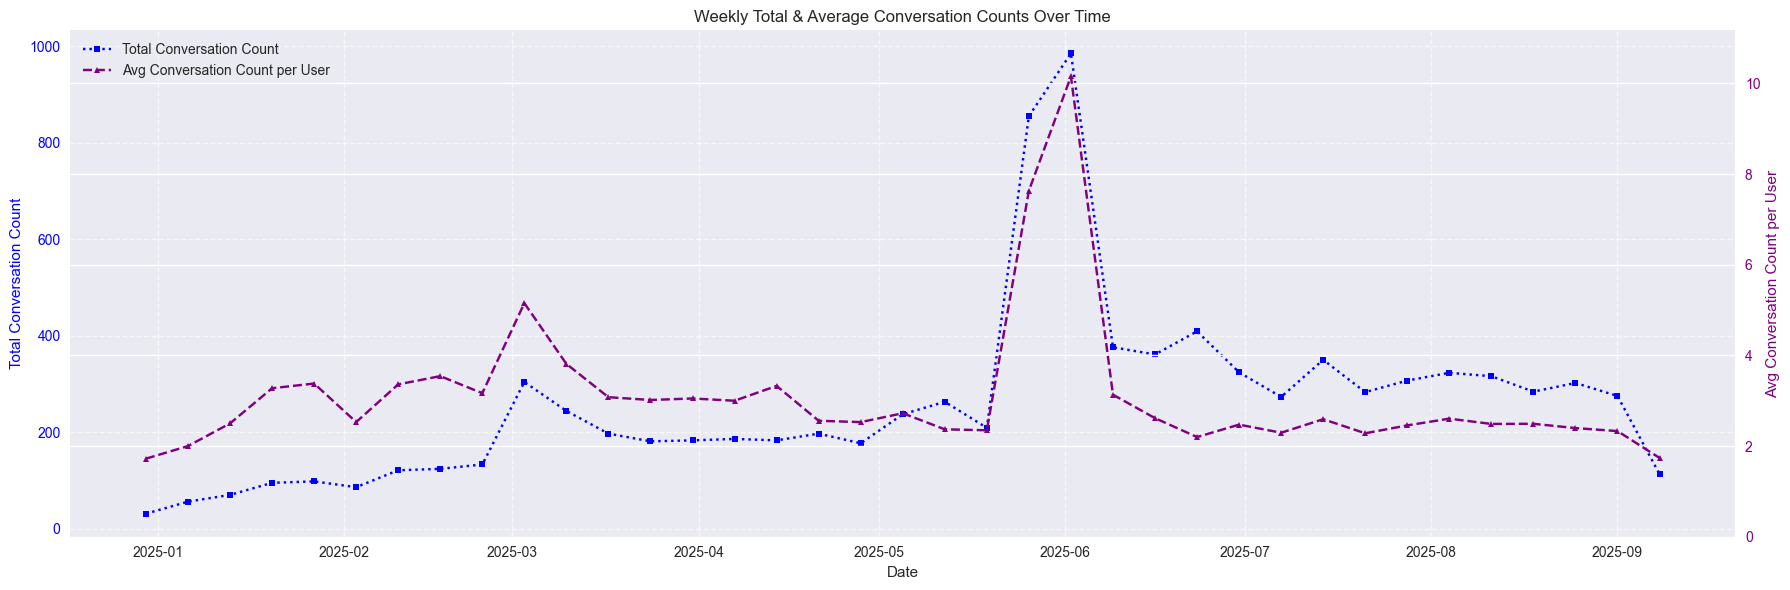

In [227]:
# Calculate total and average conversation count
total_conversation_count = weekly_active_users_df['weekly_conversation_count_per_user'].sum()
average_conversation_count_per_week = weekly_active_users_df['weekly_conversation_count_per_user'].mean()
average_conversation_count_per_user = (
    weekly_active_users_df['weekly_conversation_count_per_user']
).mean()

print(f"Total conversation count (across all weeks): {weekly_active_users_df['weekly_conversation_count_per_user'].sum():.2f}")
print(f"Average conversation count per week: {weekly_active_users_df['weekly_conversation_count_per_user'].mean():.2f}")
print(f"Average conversation count per user per week: {weekly_active_users_df['weekly_conversation_count_per_user'].mean():.2f}")

fig, ax1 = plt.subplots(figsize=(18, 6))

# Plot total conversation count on primary y-axis
ax1.plot(
    weekly_active_users_df['week_start_date'],
    weekly_active_users_df['weekly_conversation_count_per_user'] * weekly_active_users_df['weekly_active_users'],
    marker='s',
    markersize=4,
    linestyle=':',
    color='blue',
    label='Total Conversation Count'
)
ax1.set_xlabel('Date')
ax1.set_ylabel('Total Conversation Count', color='blue')
ax1.tick_params(axis='y', labelcolor='blue')
ax1.grid(True, linestyle='--', alpha=0.7)

# Create secondary y-axis for average conversation count per user
ax2 = ax1.twinx()
ax2.plot(
    weekly_active_users_df['week_start_date'],
    weekly_active_users_df['weekly_conversation_count_per_user'],
    color='purple',
    marker='^',
    markersize=4,
    linestyle='--',
    label='Avg Conversation Count per User'
)
ax2.set_ylabel('Avg Conversation Count per User', color='purple')
ax2.tick_params(axis='y', labelcolor='purple')
ax2.set_ylim(0, max(1.05, weekly_active_users_df['weekly_conversation_count_per_user'].max() * 1.1))

# Combine legends from both axes
lines_1, labels_1 = ax1.get_legend_handles_labels()
lines_2, labels_2 = ax2.get_legend_handles_labels()
ax1.legend(lines_1 + lines_2, labels_1 + labels_2, loc='upper left')

plt.title('Weekly Total & Average Conversation Counts Over Time')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

## Account Metrics

For the purposes of generating data, I bucketed the existing billing_account_id into 10 (mod 10), and created a seed file of 10 fake billing accounts, to create metrics below:


lifetime metrics per account:
- total_user_count
- total_conversation_count
- total_conversation_length_minutes
- engaged_conversation_count
- engaged_conversation_length_minutes
- seat_utilization_percentage
- average_conversation_length_minutes_60d

30, 60 , 90 day metrics of:
- user_signups
- conversation_count
- conversation_length_minutes
- engaged_conversation_count
- engaged_conversation_length_minutes
- average_conversation_length_minutes


In [223]:
print("📊 account level metrics data:")
# Comprehensive query to get account metrics
query = """
SELECT * FROM mart_account_metrics
order by 1
;
"""

account_metrics_df = conn.execute(query).fetchdf()

# Explore the DataFrame
# print("Columns:", .tolist())
print(account_metrics_df.columns)
print("\nSample data:")
account_metrics_df.head()


📊 account level metrics data:
Index(['billing_account_id', 'account_age', 'seat_quantity',
       'total_user_count', 'total_conversation_count',
       'total_conversation_length_minutes', 'engaged_conversation_count',
       'engaged_conversation_length_minutes', 'seat_utilization_percentage',
       'average_conversation_length_minutes', 'billing_account_id_1',
       'user_signups_30d', 'user_signups_60d', 'user_signups_90d',
       'conversation_count_30d', 'conversation_length_minutes_30d',
       'engaged_conversation_count_30d',
       'engaged_conversation_length_minutes_30d',
       'average_conversation_length_minutes_30d', 'conversation_count_60d',
       'conversation_length_minutes_60d', 'engaged_conversation_count_60d',
       'engaged_conversation_length_minutes_60d',
       'average_conversation_length_minutes_60d', 'conversation_count_90d',
       'conversation_length_minutes_90d', 'engaged_conversation_count_90d',
       'engaged_conversation_length_minutes_90d',
   

,billing_account_id,account_age,seat_quantity,total_user_count,total_conversation_count,total_conversation_length_minutes,engaged_conversation_count,engaged_conversation_length_minutes,seat_utilization_percentage,average_conversation_length_minutes,...,conversation_count_60d,conversation_length_minutes_60d,engaged_conversation_count_60d,engaged_conversation_length_minutes_60d,average_conversation_length_minutes_60d,conversation_count_90d,conversation_length_minutes_90d,engaged_conversation_count_90d,engaged_conversation_length_minutes_90d,average_conversation_length_minutes_90d
0,0,618,15,183,456,5957.0,379,5957.0,12.200,32.551913,...,108,269.0,93,269.0,4.483333,208,591.0,177,591.0,6.423913
1,1,627,50,191,488,2737.0,402,2737.0,3.820,14.329843,...,111,316.0,93,316.0,5.543860,208,625.0,168,625.0,6.510417
2,2,626,10,188,2190,2524.0,1360,2524.0,18.800,13.425532,...,624,757.0,410,757.0,14.283019,933,1133.0,620,1133.0,12.182796
3,3,625,200,177,595,1689.0,466,1689.0,0.885,9.542373,...,200,636.0,162,636.0,9.784615,330,1011.0,274,1011.0,10.755319
4,4,624,5,172,775,4763.0,672,4763.0,34.400,27.691860,...,225,2176.0,207,2176.0,43.520000,327,2683.0,295,2683.0,33.962025


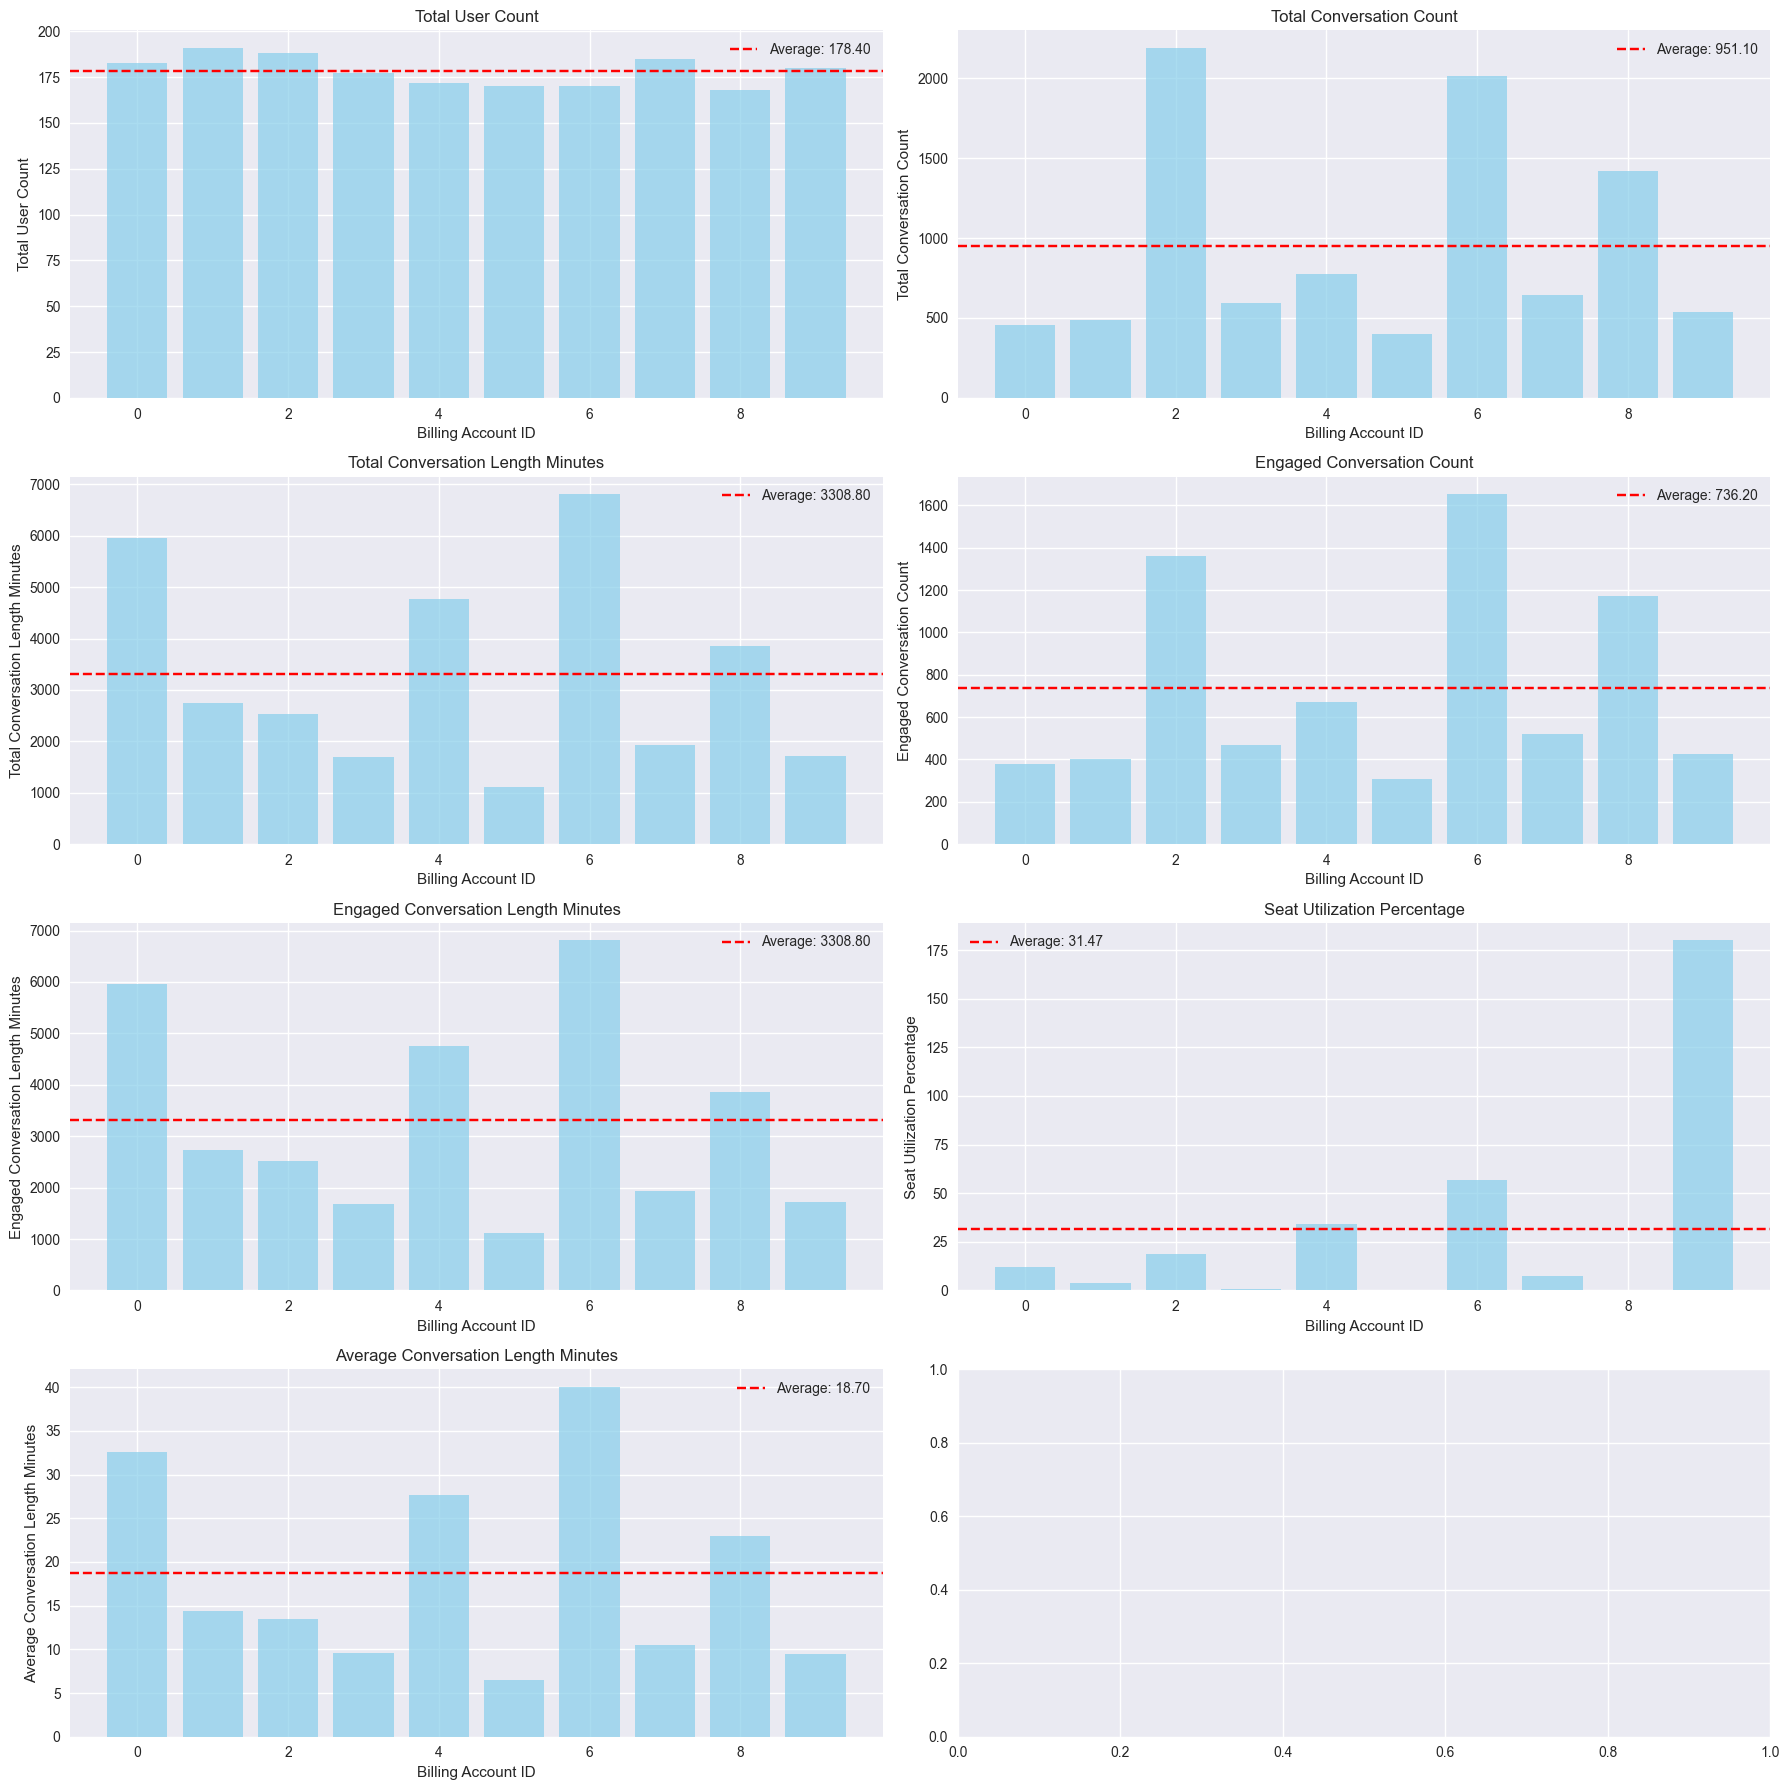

In [224]:
import matplotlib.pyplot as plt
import numpy as np

# List of metrics to plot
metrics = [
    'total_user_count',
    'total_conversation_count',
    'total_conversation_length_minutes',
    'engaged_conversation_count',
    'engaged_conversation_length_minutes',
    'seat_utilization_percentage',
    'average_conversation_length_minutes'
]

# Adjust subplot grid to fit 8 metrics (e.g., 2 rows x 4 columns)
fig, axes = plt.subplots(4, 2, figsize=(18, 18))
axes = axes.flatten()

for idx, metric in enumerate(metrics):
    ax = axes[idx]
    values = account_metrics_df[metric]
    ax.bar(account_metrics_df['billing_account_id'], values, color='skyblue', alpha=0.7)
    avg = values.mean()
    ax.axhline(avg, color='red', linestyle='--', label=f'Average: {avg:.2f}')
    ax.set_title(metric.replace('_', ' ').title())
    ax.set_xlabel('Billing Account ID')
    ax.set_ylabel(metric.replace('_', ' ').title())
    ax.legend()

plt.tight_layout()
plt.show()


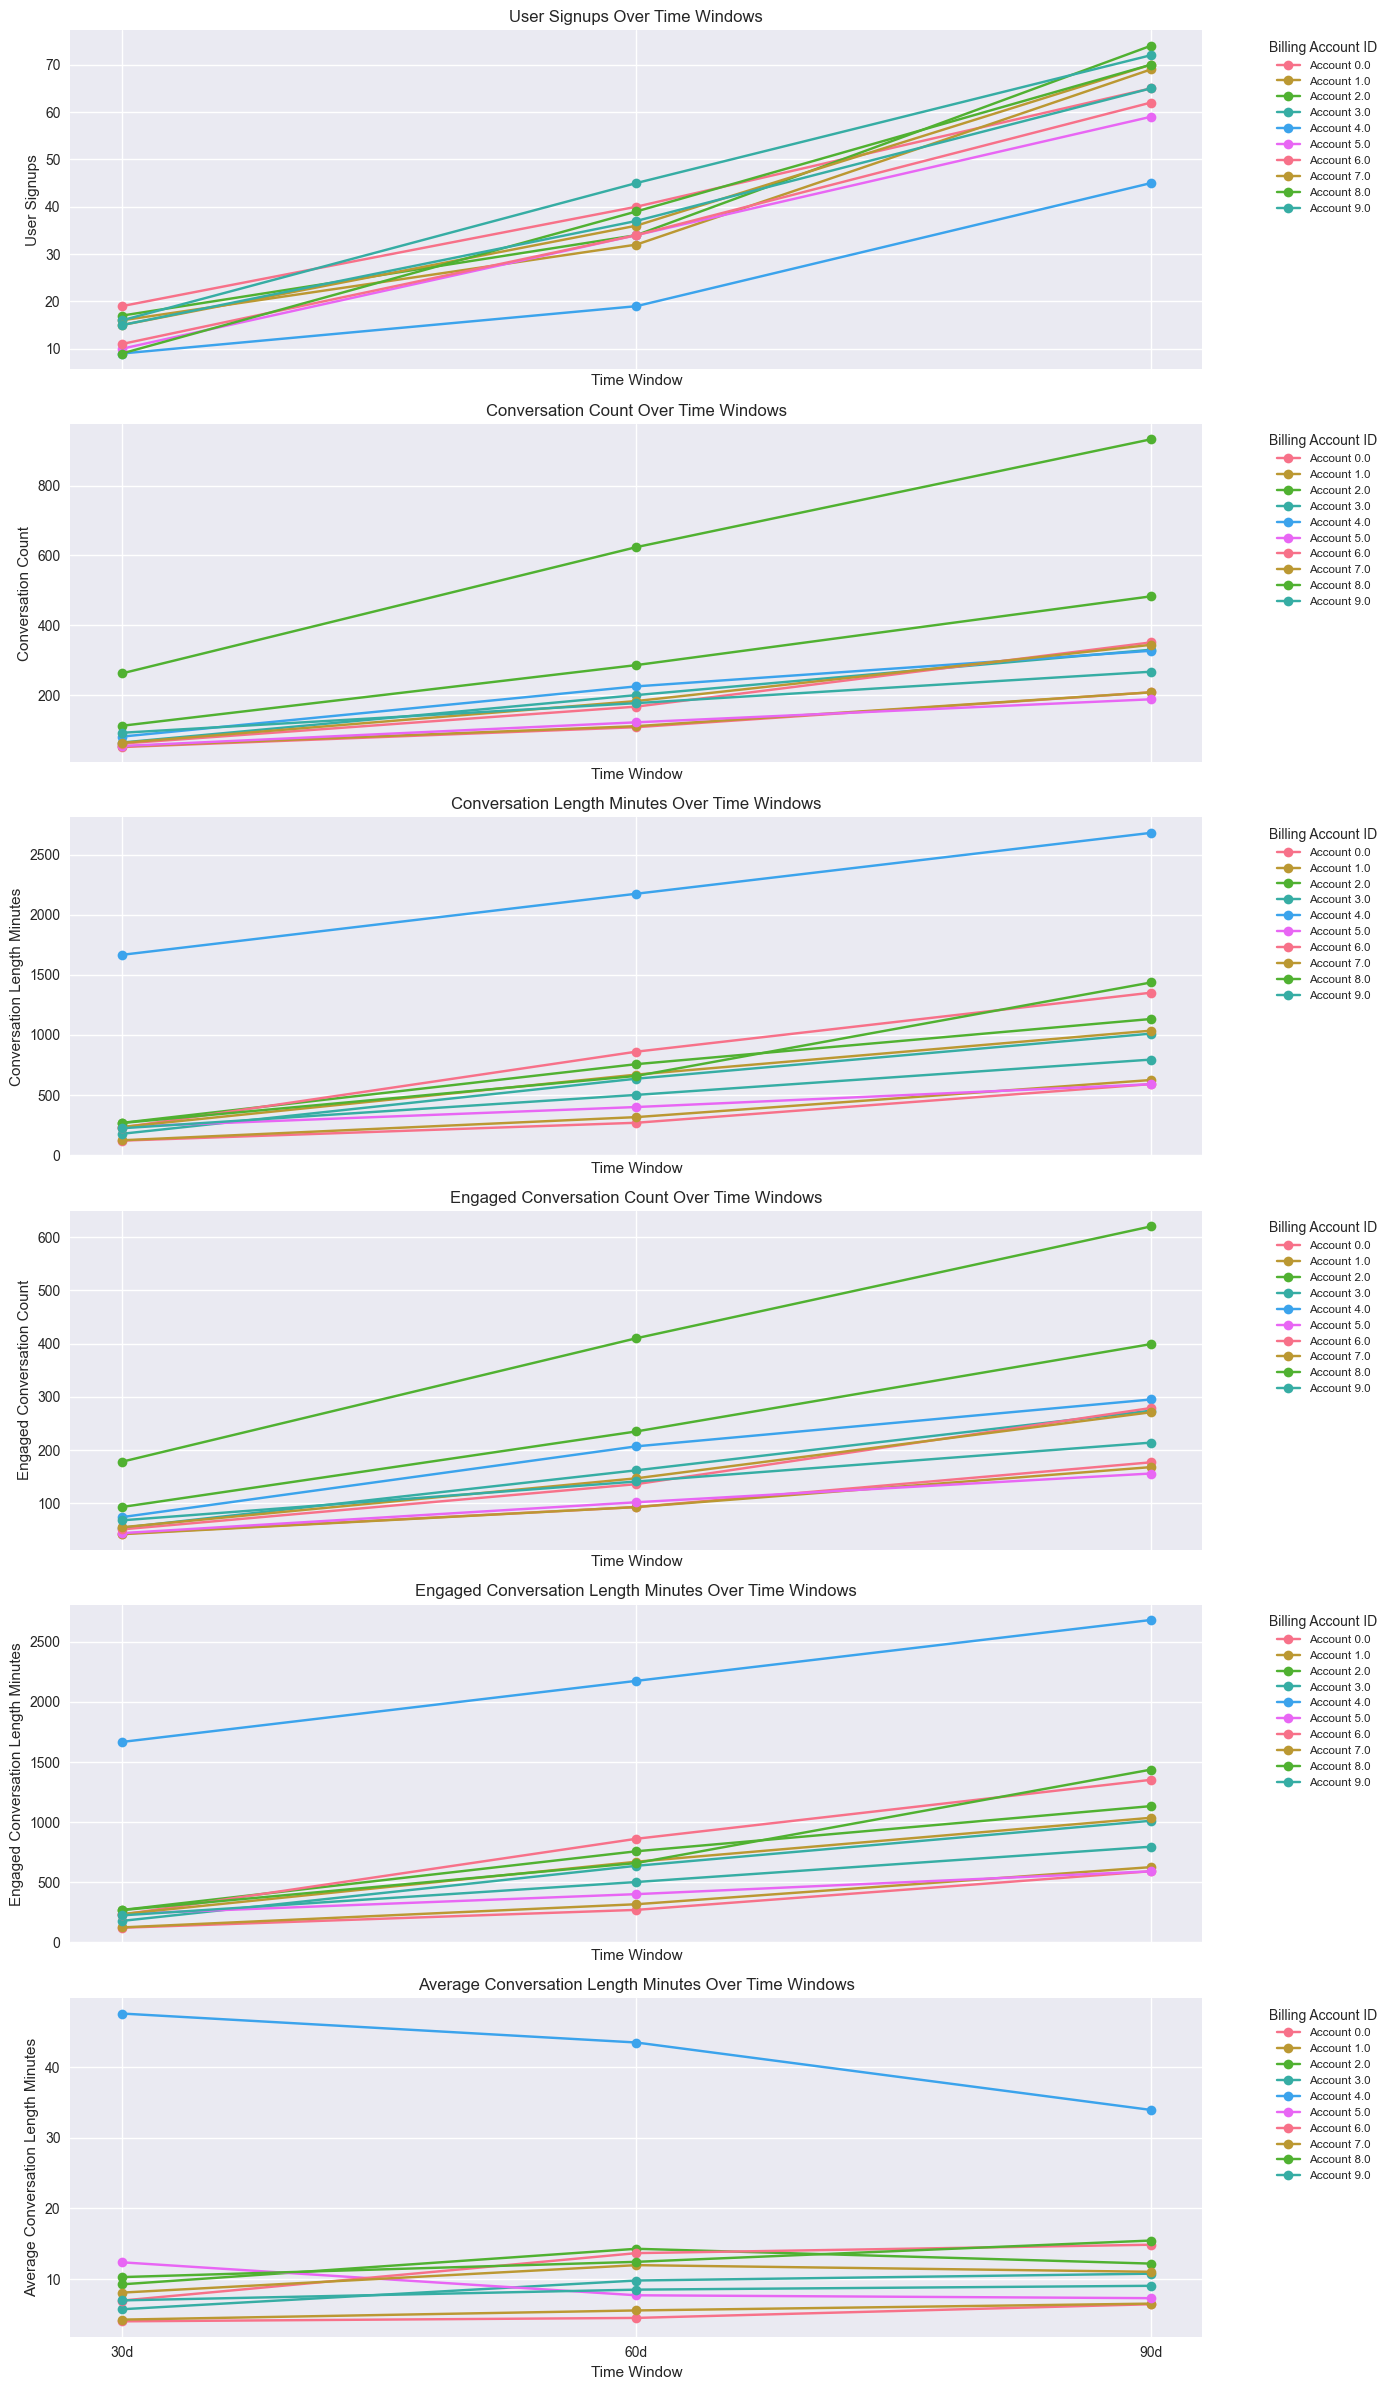

In [225]:
# Plot time series metrics (30d, 60d, 90d) for each billing account

import matplotlib.pyplot as plt

# Define the metrics and their time windows
time_windows = ['30d', '60d', '90d']
base_metrics = [
    'user_signups',
    'conversation_count',
    'conversation_length_minutes',
    'engaged_conversation_count',
    'engaged_conversation_length_minutes',
    'average_conversation_length_minutes'
]

# For each base metric, plot the 30d, 60d, 90d values for each billing account
fig, axes = plt.subplots(len(base_metrics), 1, figsize=(14, 4 * len(base_metrics)), sharex=True)

billing_account_ids = account_metrics_df['billing_account_id']

for idx, base_metric in enumerate(base_metrics):
    ax = axes[idx]
    for i, row in account_metrics_df.iterrows():
        y = [row[f"{base_metric}_{window}"] for window in time_windows]
        ax.plot(time_windows, y, marker='o', label=f"Account {row['billing_account_id']}")
    ax.set_title(f"{base_metric.replace('_', ' ').title()} Over Time Windows")
    ax.set_xlabel("Time Window")
    ax.set_ylabel(base_metric.replace('_', ' ').title())
    ax.legend(title="Billing Account ID", bbox_to_anchor=(1.05, 1), loc='upper left', fontsize='small')

plt.tight_layout()
plt.show()


In [226]:
conn.close()
